In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from transformers import BarthezTokenizer, TFBartForSequenceClassification,BertTokenizer,TFBertForSequenceClassification
from tensorflow.keras.layers import Embedding, GRU, Dense


In [159]:
df=pd.read_csv('/content/auto-labelling (1).csv')
df.head()

,Product Description,Category,Uniq Id
0,"Sunny Isle Ylang Jamaican Black Castor Oil, 8 oz",Hair Care,c4fa57c1506c1fc7c42c853c73248dc2
1,"Crafted with organic aloe vera extracts, this ...",Hair Care,d14c60b116211fb6219d7d2b7e2293af
2,Eufora Beautifying Elixirs Bodifying Condition...,Hair Care,cd2cf57e9280a29f4a6cc5417d28231b
3,Indigo Powder:- The Indigo powder is made usin...,Hair Care,74ce49f475ddd0985ea41414b468be4b
4,Oil has been used for thousands of years for i...,Hair Care,a62fe6e3e986f0a75f9d9ed59c4dc1a8


In [160]:
def data_cleaning(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text


In [161]:
df["Product Description"]=df["Product Description"].apply(data_cleaning)

In [162]:
df["Category"].value_counts()

,count
Category,
Hair Care,100
Skin Care,100


In [163]:
df.isnull().sum()

,0
Product Description,0
Category,0
Uniq Id,0


In [164]:
df.duplicated().sum()

0

In [165]:
X = df['Product Description']
y = df['Category']

In [166]:
x_train,x_test,y_train,y_test= train_test_split(X,y,random_state=1,shuffle=True,test_size=0.30)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((140,), (60,), (140,), (60,))

### Creating the Gru For the sentimental analysis

In [167]:
max_feature =10000 #max num of words to keep
max_len = 200 #max length of each sentence
embedding_dim = 128 #dimention of embedding vector
batch_size = 2
epochs = 100

In [168]:
## Encoding the y_labels
label_encoder=LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)
y_test

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [169]:
y_train

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0])

In [170]:

# Initialize the tokenizer and fit it on the product descriptions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text descriptions to sequences of integers
x_train_sequences = tokenizer.texts_to_sequences(x_train)

# Pad sequences to make them the same length
max_length = 50  # You can adjust this based on your needs
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length)

# Now, x_train_padded contains the padded tokenized sequences of integers.



# Initialize the tokenizer and fit it on the product descriptions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_test)

# Convert text descriptions to sequences of integers
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences to make them the same length
max_length = 50  # You can adjust this based on your needs
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length)

# Now, x_train_padded contains the padded tokenized sequences of integers.


In [171]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=50000, output_dim=64, input_length=200),  # Add input_length
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.build(input_shape=(None, 200))  # Batch size is flexible (None), and each input sequence is 200 tokens long
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)             │ (None, 200, 64)             │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_59 (GRU)                         │ (None, 200, 128)            │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 200, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_60 (GRU)                         │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,314,402 (12.64 MB)

 Trainable params: 3,314,146 (12.64 MB)

 Non-trainable params: 256 (1.00 KB)

In [173]:
# Define the model architecture
max_length = max(len(seq) for seq in sequences)
model = tf.keras.Sequential()
model.add(Embedding(input_dim=50000,
                    output_dim=64,
                    input_length=max_length))  # Adjust according to your text input length

# Add GRU layers with Dropout and Batch Normalization
model.add(GRU(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

model.add(GRU(64))
model.add(tf.keras.layers.Dropout(0.5))

# Output layer for binary classification
model.add(tf.keras.layers.Dense(1, activation='softmax') ) # Single unit for binary classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Ensure y_train has the shape (n_samples, 1) for binary classification

call_back = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
# Train the model
history = model.fit(
    x_train_padded,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_padded,y_test),
    callbacks=[call_back],
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (2, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(2, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.4469 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.5459 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5173 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5017 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00


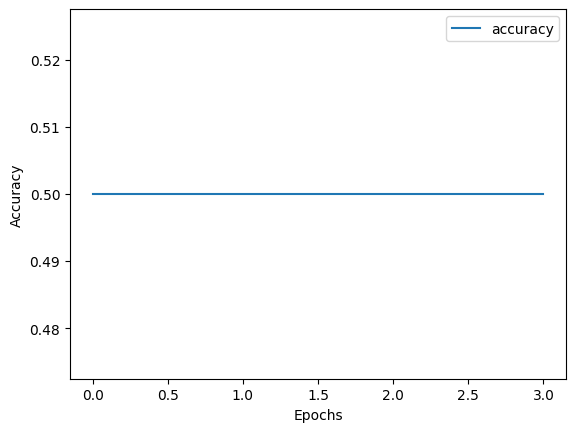

In [174]:
plt.plot(history.history.get('accuracy'))
# plt.plot(history.history.get('val_accuracy'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

In [149]:
loss, accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5764 - loss: 1.2729
Test Accuracy: 0.58


In [150]:
predictions = model.predict(x_test_padded)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step


In [151]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.5328 - loss: 0.6914 - val_accuracy: 0.6500 - val_loss: 0.6881
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.6747 - loss: 0.6802 - val_accuracy: 0.6250 - val_loss: 0.6767
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.8305 - loss: 0.6355 - val_accuracy: 0.7250 - val_loss: 0.6158
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.9141 - loss: 0.3818 - val_accuracy: 0.8250 - val_loss: 0.4841
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - accuracy: 0.9660 - loss: 0.1104 - val_accuracy: 0.7750 - val_loss: 0.5694
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9745 - loss: 0.0764 - val_accuracy: 0.7250 - val_loss: 0.6844
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.9675 - loss: 0.1097 - val_accuracy: 0.7750 - val_loss: 0.5065
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.9677 - loss: 0.0738 - val_accuracy: 0.825

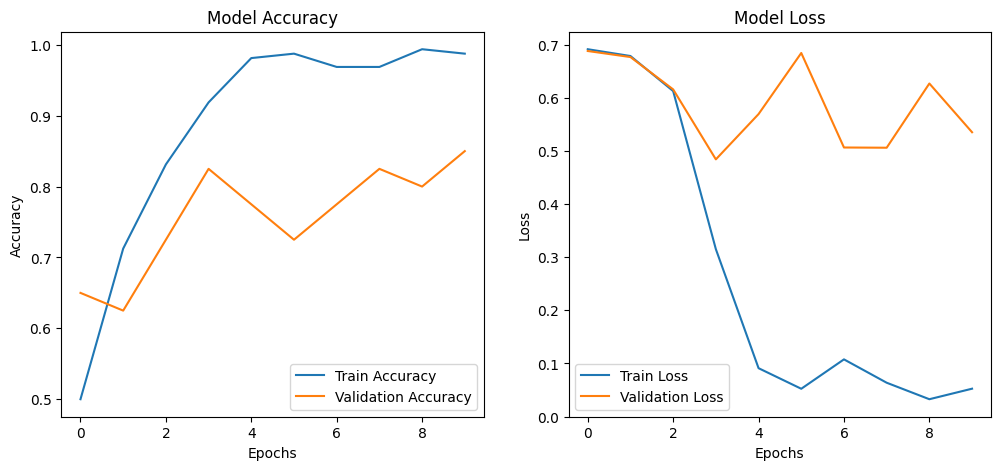

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step

Actual vs Predicted Categories:
Actual: Hair Care  |  Predicted: Hair Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Hair Care  |  Predicted: Hair Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Pre

In [154]:
from tensorflow.keras.utils import to_categorical, plot_model
texts = df["Product Description"].values
labels = df["Category"].values

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Tokenization
tokenizer = Tokenizer(num_words=5000,lower=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_categorical, test_size=0.2, random_state=42)

# Build the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Plot the model architecture
# plot_model(model, to_file="gru_model.png", show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Get predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# Convert numerical predictions back to category names
predicted_categories = label_encoder.inverse_transform(predicted_labels)
actual_categories = label_encoder.inverse_transform(actual_labels)

# Print actual vs predicted results
print("\nActual vs Predicted Categories:")
for i in range(len(actual_categories)):
    print(f"Actual: {actual_categories[i]}  |  Predicted: {predicted_categories[i]}")
